In [1]:
%matplotlib inline
%load_ext watermark
%watermark -v -p numpy,scipy,pandas,matplotlib,seaborn,sklearn

CPython 3.4.3
IPython 5.1.0

numpy 1.10.4
scipy 0.18.1
pandas 0.19.1
matplotlib 1.5.3
seaborn 0.7.1
sklearn 0.18


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import seaborn as sns
from time import time

from pandas import set_option
set_option("display.max_rows", 20)
pd.options.mode.chained_assignment = None

### Load the header

In [3]:
dataset_header = pd.read_csv('data/Datamatrix_header.txt', names=['Header'])
header = dataset_header['Header'].tolist()

### Load the dataset

In [4]:
dataset_training = pd.read_csv('data/Dataset_all_training.dat', sep="  ", names=header)

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [5]:
# Change variable type
dataset_training['PseudoLitho'] = dataset_training['PseudoLitho'].astype('int')
dataset_training['RockCode'] = dataset_training['RockCode'].astype('int')
dataset_training['Outcome'] = dataset_training['Outcome'].astype('int')

New variable `Mineralization` indicate if the cell is mineralized (1) or not (0)

In [6]:
dataset_training['Class'] = dataset_training.apply(lambda row: 0 if row["Outcome"] == 0 else 1, axis=1)

Replce `NaN` values with -99999. The classifier is able to deal with extreme values outside of the variable range. 

In [8]:
dataset_training.replace(to_replace=np.nan,value=-99999.0,inplace=True)

In [9]:
dataset_training.describe()

,Count_Fault_Crossing,Dist_2_CDI,distance_to_Fault_Network,Distance_to_AuGt150,Distance_to_CuGt2000,Distance_to_high_curvature_along_faults,GRAV_effective_density,Gravity_1VD,Gravity_Analytic_Signal,Kpct,PseudoLitho,RockCode,Thppm,TMI_1VD,TMI_Analytic_Signal,TMI_effective_susc,U_div_Th,Uppm,Outcome,Class
count,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000,748856.000000
mean,0.060804,2340.536986,3375.910952,7863.664750,3970.545994,4926.313706,-0.076733,-7.211228,-7.209100,1.979132,6.536771,7.915371,26.752967,0.005754,0.780903,0.075429,0.165614,3.638915,0.055907,0.003272
std,0.076219,2396.922399,3608.783990,5908.366423,3309.401231,4733.490670,0.137079,849.137478,849.137496,1.174467,4.130024,3.390040,23.482837,0.894300,1.022955,0.058222,1.501321,2.358552,1.123281,0.057105
min,0.000000,0.000128,0.006518,125.035000,125.560000,9.895720,-0.369478,-99999.000000,-99999.000000,-0.299976,1.000000,1.000000,-1.283310,-10.802200,0.003949,-0.070242,-918.141000,-0.442142,0.000000,0.000000
25%,0.000000,505.764500,862.716250,2835.860000,1454.567500,1748.530000,-0.182438,-0.001312,0.001254,1.008980,2.000000,5.000000,12.653300,-0.291891,0.255740,0.028222,0.118626,2.070980,0.000000,0.000000
50%,0.028723,1537.370000,2188.450000,6393.605000,2834.870000,3507.245000,-0.081081,-0.000402,0.001731,1.820080,6.000000,7.000000,17.059600,-0.073387,0.477557,0.073202,0.152430,2.946285,0.000000,0.000000
75%,0.100000,3509.162500,4446.470000,12181.000000,5610.445000,6279.570000,0.017653,0.000613,0.002271,2.734492,7.000000,12.000000,30.416500,0.192651,0.912613,0.127128,0.193580,4.488950,0.000000,0.000000
max,0.569841,14583.900000,22446.700000,25069.800000,16842.500000,27137.600000,0.261280,0.005052,0.005255,8.227270,15.000000,13.000000,211.651000,23.341500,24.067600,0.332257,20.081400,35.072800,33.000000,1.000000


The dataset is diveded in features (X) and labels (y). y correspond to the presence/absence of the mineralization.

In [10]:
#  drop the labels as well 'Distance_to_AuGt150','Distance_to_CuGt2000' as higly correlated with the training sites.
X = dataset_training.drop(['Outcome','Class', 'Distance_to_AuGt150','Distance_to_CuGt2000'],axis=1).values
y = dataset_training['Class'].values

The labels are highly unbalanced, i.e. there are much more non-mineralized then mineralized class. See figure below.

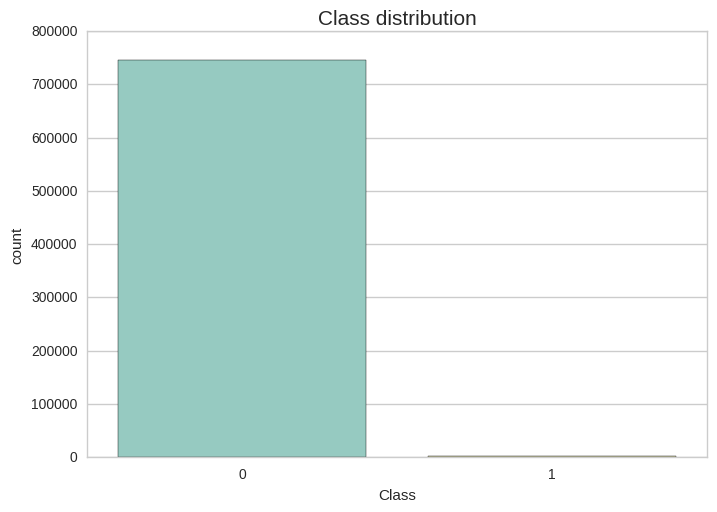

In [11]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.countplot(x='Class',data=dataset_training, palette="Set3")
ax.set_title('Class distribution', fontsize=15)

### Classification
Here we use Random Forest for the classification. The unbalance is taken account into the algorithm directely by give a `sample_weight` parameter. For this work we use 1000 trees in the forest. 

The dataset has been divided in 0.33/0.66 test/training size and a cross validation with 5 folds has been run.

The result metrics are displayed for each fold as well as a receiver operator characteristic (ROC) plot which illustrates the performance of a binary classifier system. It is created by plotting the fraction of true positives out of the positives (TPR = true positive rate) vs. the fraction of false positives out of the negatives (FPR = false positive rate).

******** Result fold 1 *********
TP:261
FP:2
Accuracy: 99.9314%
Precision: 99.2395%
Recall: 81.5625%
F1-score: 89.5369%

******** Confusion matrix fold 1 *********
Predicted      0    1    All
True                        
0          88643    2  88645
1             59  261    320
All        88702  263  88965
******** Result fold 2 *********
TP:249
FP:8
Accuracy: 99.9112%
Precision: 96.8872%
Recall: 77.8125%
F1-score: 86.3085%

******** Confusion matrix fold 2 *********
Predicted      0    1    All
True                        
0          88637    8  88645
1             71  249    320
All        88708  257  88965
******** Result fold 3 *********
TP:243
FP:6
Accuracy: 99.9067%
Precision: 97.5904%
Recall: 75.9375%
F1-score: 85.4130%

******** Confusion matrix fold 3 *********
Predicted      0    1    All
True                        
0          88639    6  88645
1             77  243    320
All        88716  249  88965
******** Result fold 4 *********
TP:239
FP:1
Accuracy: 99.9078%
Precision

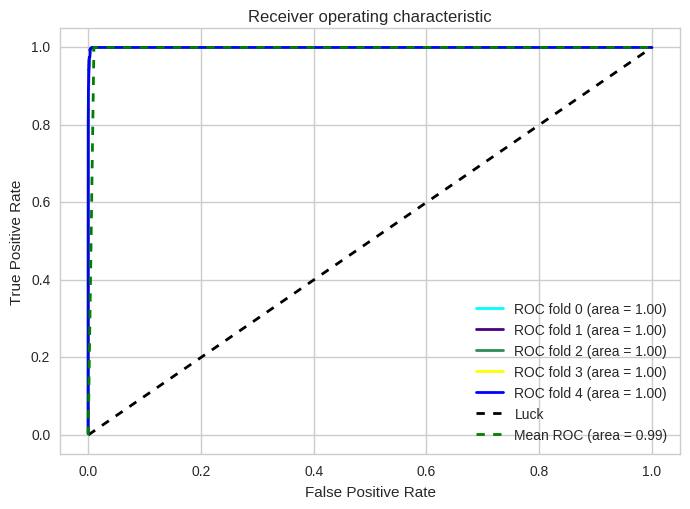

Total running time of the script 1462.45 seconds


In [13]:
start = time()
dataset_training = dataset_training.sample(frac=0.6, replace=True)

X = dataset_training.drop(['Outcome','Class'],axis=1).values
y = dataset_training['Class'].values

target_names = ['non-mineralized','mineralized']

from itertools import cycle
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn import ensemble
from sklearn import metrics
from scipy import interp
# Run classifier with stratified cross-validation on five folds and plot ROC curves
cv = StratifiedShuffleSplit(n_splits=5,test_size=0.33)

clf = ensemble.RandomForestClassifier(n_estimators=1000, random_state=123)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

from collections import Counter

prediciton = []
i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    cnt = Counter(y[train])
    w0 = cnt[1]/len(y[train]) # weight associated to 0's
    w1 = cnt[0]/len(y[train]) # weight associated to 1's
    clf.fit(X[train], y[train], sample_weight=np.array([w0 if r==0 else w1 for r in y[train]]))
    probas_ = clf.predict_proba(X[test])
    preds_ = clf.predict(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = metrics.roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = metrics.auc(fpr, tpr)
    ACC = metrics.accuracy_score(y[test],preds_)
    precision, recall, thresholds = metrics.precision_recall_curve(y[test], probas_[:, 1])
    cm = metrics.confusion_matrix(y[test],preds_)
    # Display results
    print('='*30)
    print('******** Result fold {} *********'.format(i+1))
    print("TP:{}".format(cm[1,1], cm[1,1]/(cm.sum()+0.0)))
    print("FP:{}".format(cm[0,1], cm[0,1]/(cm.sum()+0.0)))
    print('Accuracy: {:.4%}'.format(ACC))
    print('Precision: {:.4%}'.format(metrics.precision_score(y[test], clf.predict(X[test]))))
    print('Recall: {:.4%}'.format(metrics.recall_score(y[test], clf.predict(X[test]))))
    print('F1-score: {:.4%}'.format(metrics.f1_score(y[test], clf.predict(X[test]))))
    print('\n******** Confusion matrix fold {} *********'.format(i+1))
    print(pd.crosstab(y[test], preds_, rownames=['True'], colnames=['Predicted'], margins=True))
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = metrics.auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
print('Total running time of the script {:.2f} seconds'.format(time() - start))